In [1]:
# PyTorch 的核心组件，用于构建和训练神经网络
import os
import torch
import torch.autograd as autograd # 自动微分模块，用于计算梯度
import torch.nn as nn # 构建神经网络的模块
import torch.nn.functional as F # 函数式接口，提供激活函数
import torch.optim as optim # 优化器模块

# 处理数据集
import torch.utils.data as Data # 数据加载模块
torch.manual_seed(8) # 设置随机种子以保证实验结果可复现

import time
import numpy as np

# 清理垃圾回收
import gc # 垃圾回收模块，可以手动释放内存防止 GPU 占用过多

import sys
sys.setrecursionlimit(50000) # 增加 Python 的递归限制，防止某些深层嵌套函数（如图遍历）报错

import pickle # Python 原生对象序列化/反序列化工具，常用于缓存数据
torch.backends.cudnn.benchmark = True # 如果输入尺寸变化不大，可提升 CNN 速度
torch.set_default_tensor_type('torch.cuda.FloatTensor') # 将默认张量类型设置为 GPU 浮点型，加快训练速度（前提是有 GPU）

from tensorboardX import SummaryWriter # tensorboardX 可用于可视化训练过程（建议后续加回，帮助数据可视化）
torch.nn.Module.dump_patches = True # 在模型出现错误时，帮助调试模块
import copy # 提供深拷贝功能，模型保存常用
import pandas as pd # 用于处理表格数据（如 CSV），是分析化学分子数据的重要工具
#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

/root/miniconda3/lib/python3.12/site-packages/torch/__init__.py:747: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:431.)
  _C._set_default_tensor_type(t)


In [2]:
from rdkit import Chem # RDKit 的核心模块，处理分子对象、SMILES、原子等
# from rdkit.Chem import AllChem
from rdkit.Chem import QED # 计算 drug-likeness（药物相似度）的指标
from rdkit.Chem import rdMolDescriptors, MolSurf # 分子描述符，如 TPSA（极性表面积）、分子质量等 ; 分子表面计算（比如 PSA）
from rdkit.Chem.Draw import SimilarityMaps # 可视化原子重要性（如注意力分布图）
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor # 2D 分子图形绘制与布局控制
from rdkit.Chem.Draw import rdMolDraw2D # 2D 分子图形绘制与布局控制

%matplotlib inline
from numpy.polynomial.polynomial import polyfit # 多项式拟合（用于趋势线）

# 标准绘图模块，色图、颜色映射等
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

# 用于在 Jupyter notebook 中显示 RDKit 生成的 SVG 分子图
import seaborn as sns; sns.set()
from IPython.display import SVG, display
import sascorer

number of all smiles:  9999
number of successfully processed smiles:  9999


/tmp/ipykernel_6554/1289301914.py:40: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(atom_num_dist, bins=28, kde=False)


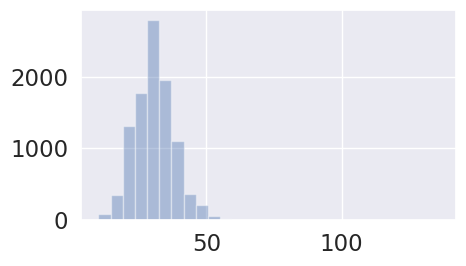

Average atoms: 30.36, Max: 136, Min: 10


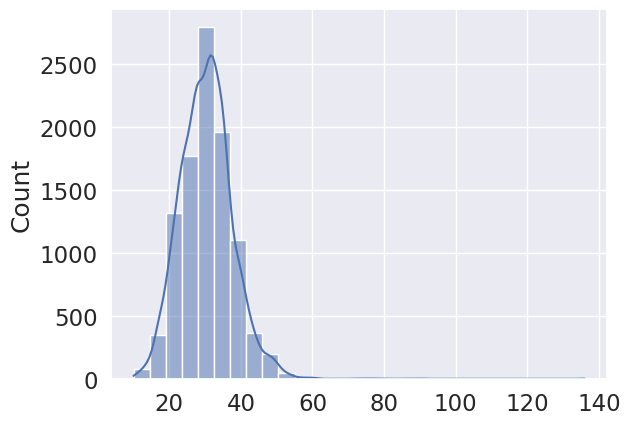

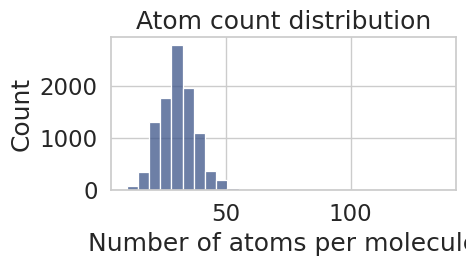

In [3]:
# 数据预处理（1.读取 Malaria Bioactivity 数据集；2.清洗错误分子；3.Canonical SMILES 规范化；4.分析原子数分布，并用 Seaborn 绘图展示）

# 1.数据集名称
task_name = 'Malaria Bioactivity'
tasks = ['Loge EC50'] # 下游预测任务的目标列

raw_filename = "../data/malaria-processed.csv" #  CSV 文件路径
feature_filename = raw_filename.replace('.csv','.pickle') # 派生文件名（如后续保存为 .pickle）
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')  # 提取文件前缀用于命名图片等文件（malaria-processed）

# 2.加载数据（从 CSV 文件读取数据，SMILES 列作为分子结构）
smiles_tasks_df = pd.read_csv(raw_filename, names = ["Loge EC50", "smiles"]) # Loge EC50 是生物活性值（对数变换的 EC50）
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList)) # 打印所有 SMILES 的数量

# 3.分子验证+原子数量统计+Canoical SMILES规范化
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles) # 使用 Chem.MolFromSmiles(smiles) 判断 SMILES 是否能正确解析为分子结构
        atom_num_dist.append(len(mol.GetAtoms())) # 统计每个分子的原子数，用于后续绘图；
        remained_smiles.append(smiles) 
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True)) # 生成 canonical smiles（规范形式），确保输入的一致性
    except: # 错误的 SMILES 会被忽略（例如：原始数据有误）。
        print(smiles)
        pass

# 4.过滤无效 SMILES，更新 DataFrame
print("number of successfully processed smiles: ", len(remained_smiles)) # 只保留合法分子
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)] # 新增一列 cano_smiles，为标准化后的 SMILES 表达
# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list

# 5. 绘制分子原子数量分布图
plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()

# 6.后面增加的部分（平均分子、重新绘图）
print(f"Average atoms: {np.mean(atom_num_dist):.2f}, Max: {np.max(atom_num_dist)}, Min: {np.min(atom_num_dist)}")
# 显示原子数为 10、20、30 的分子（如果存在）
for target_num in [10, 20, 30]:
    try:
        idx = atom_num_dist.index(target_num)
        mol = Chem.MolFromSmiles(remained_smiles[idx])
        display(Draw.MolToImage(mol, size=(300,300), kekulize=True))
        print(f"Example with {target_num} atoms")
    except:
        continue
        
sns.histplot(atom_num_dist, bins=28, kde=True)

# 参考 Nature 风格色板（根据文献和图表采样）
NATURE_COLORS = [
    "#3C5488",  # dark blue
    "#E64B35",  # red
    "#00A087",  # teal
    "#F39B7F",  # light coral
    "#4DBBD5",  # cyan blue
    "#8491B4",  # light blue-purple
    "#91D1C2",  # mint green
]

plt.figure(figsize=(5, 3))
sns.set(style="whitegrid", font_scale=1.5)
ax = sns.histplot(atom_num_dist, bins=28, kde=False, color=NATURE_COLORS[0])
plt.xlabel("Number of atoms per molecule")
plt.ylabel("Count")
plt.title("Atom count distribution")
plt.tight_layout()
plt.show()

In [4]:
import json

random_seed = 68
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 200 # 每轮训练中使用的样本批次大小
epochs = 800 # 最多训练轮数，结合早停机制可能不会训练满

p_dropout= 0.03 # Dropout 概率，防止过拟合，值较小说明对正则化要求不高
fingerprint_dim = 200 #  GNN 输出的指纹向量维度，也就是每个分子最终嵌入的表示维度

weight_decay = 4.3 # (也称 L2 正则项系数)
learning_rate = 4 # # 注意这个值很高，是否使用了 scheduler 或归一化？
radius = 2 # 图神经网络传播的半径（message passing steps），通常用于 Morgan Fingerprint/GNN
T = 1 # 图神经网络的层数或时间步（视具体实现）——这里等于 1，表示 GNN 信息传播轮数为 1
per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num

config_dict = {
    "start_time": start_time,
    "random_seed": random_seed,
    "batch_size": batch_size,
    "epochs": epochs,
    "fingerprint_dim": fingerprint_dim,
    "dropout": p_dropout,
    "radius": radius,
    "T": T,
    "learning_rate": learning_rate,
    "weight_decay": weight_decay,
    "output_units_num": output_units_num,
    "tasks": tasks
}
save_dir = "config"
os.makedirs(save_dir, exist_ok=True)
# 保存配置文件
config_path = os.path.join(save_dir, f"config_{prefix_filename}_{start_time}.json")
with open(config_path, "w") as f:
    json.dump(config_dict, f, indent=4)

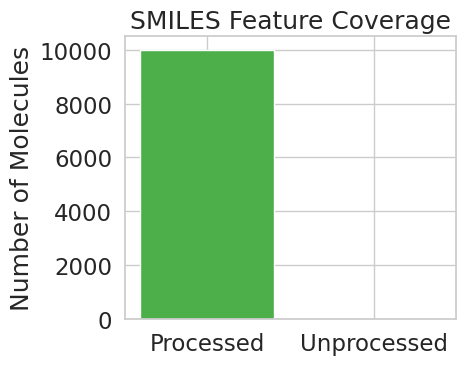

Total SMILES: 9999
Covered SMILES: 9999
Uncovered SMILES: 0


In [5]:
# 特征处理与过滤无效数据（这是一个缓存机制。如果之前已经处理过分子的图结构特征，存在 feature_filename（如 malaria-processed.pickle），就直接加载；
# 否则就调用自定义函数 save_smiles_dicts(...) 对所有 SMILES 做特征提取，并保存为 pickle 文件，避免下次重复计算。）
if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)
remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)

# 数据可视化
labels = ['Processed', 'Unprocessed']
counts = [len(remained_df), len(uncovered_df)]
plt.figure(figsize=(5, 4))
plt.bar(labels, counts, color=['#4daf4a', '#e41a1c'])
plt.title("SMILES Feature Coverage")
plt.ylabel("Number of Molecules")
plt.tight_layout()
plt.show()

# 日志提示
print(f"Total SMILES: {len(smiles_tasks_df)}")
print(f"Covered SMILES: {len(remained_df)}")
print(f"Uncovered SMILES: {len(uncovered_df)}")

Training set size: 7999
Test set size: 2000


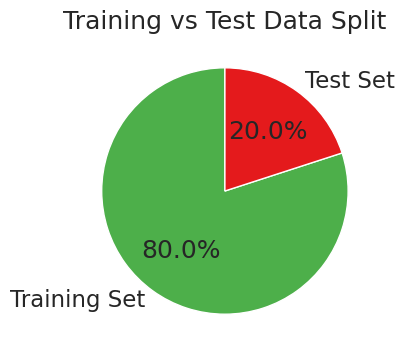

In [6]:
test_df = remained_df.sample(frac=0.2,random_state=random_seed) # 从 remained_df 中随机抽取 20% 的样本作为测试集;指定随机种子，确保每次划分数据时都能保持一致的结果，便于复现
train_df = remained_df.drop(test_df.index)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
# print(len(test_df),sorted(test_df.cano_smiles.values))

# 在划分后打印一下训练集和测试集的大小，方便后续追踪
print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

# 用图表直观显示训练集与测试集的比例
labels = ['Training Set', 'Test Set']
sizes = [len(train_df), len(test_df)]
colors = ['#4daf4a', '#e41a1c']

plt.figure(figsize=(5, 4))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title("Training vs Test Data Split")
plt.show()


toal params in model: 863604
atom_fc.weight torch.Size([200, 39])
atom_fc.bias torch.Size([200])
neighbor_fc.weight torch.Size([200, 49])
neighbor_fc.bias torch.Size([200])
GRUCell.0.weight_ih torch.Size([600, 200])
GRUCell.0.weight_hh torch.Size([600, 200])
GRUCell.0.bias_ih torch.Size([600])
GRUCell.0.bias_hh torch.Size([600])
GRUCell.1.weight_ih torch.Size([600, 200])
GRUCell.1.weight_hh torch.Size([600, 200])
GRUCell.1.bias_ih torch.Size([600])
GRUCell.1.bias_hh torch.Size([600])
align.0.weight torch.Size([1, 400])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 400])
align.1.bias torch.Size([1])
attend.0.weight torch.Size([200, 200])
attend.0.bias torch.Size([200])
attend.1.weight torch.Size([200, 200])
attend.1.bias torch.Size([200])
mol_GRUCell.weight_ih torch.Size([600, 200])
mol_GRUCell.weight_hh torch.Size([600, 200])
mol_GRUCell.bias_ih torch.Size([600])
mol_GRUCell.bias_hh torch.Size([600])
mol_align.weight torch.Size([1, 400])
mol_align.bias torch.Size([1])
mol_

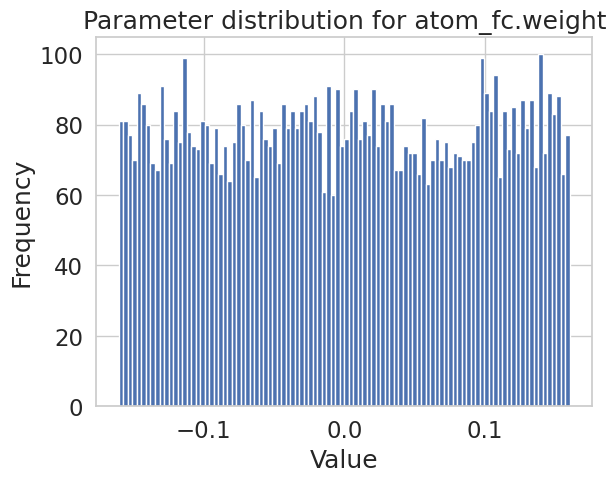

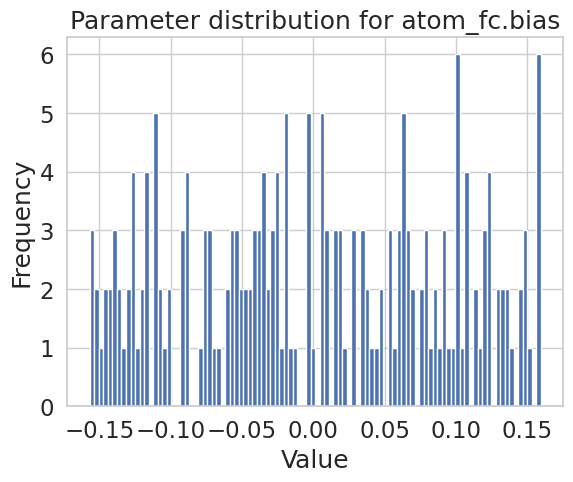

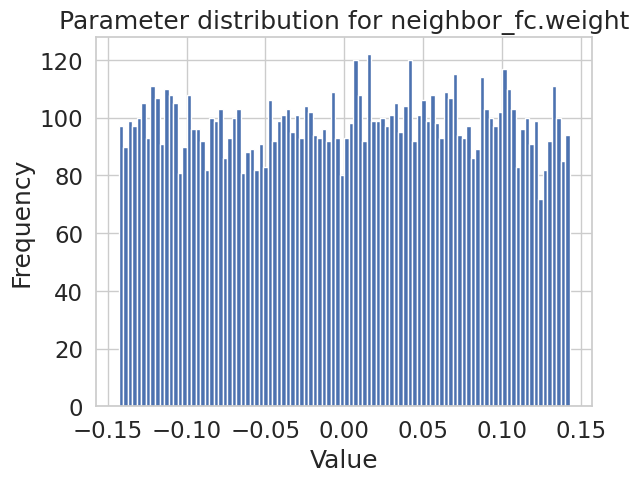

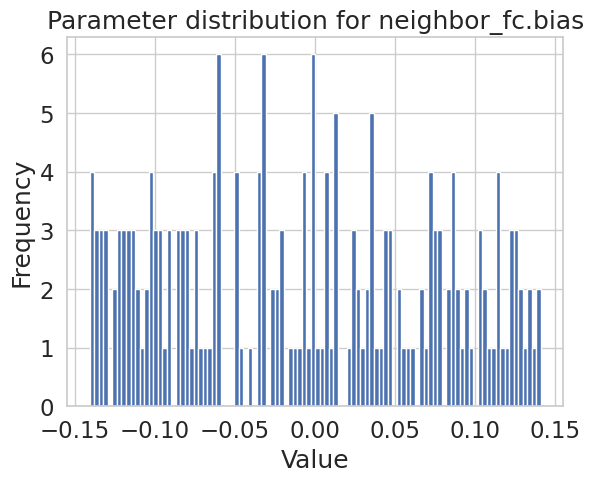

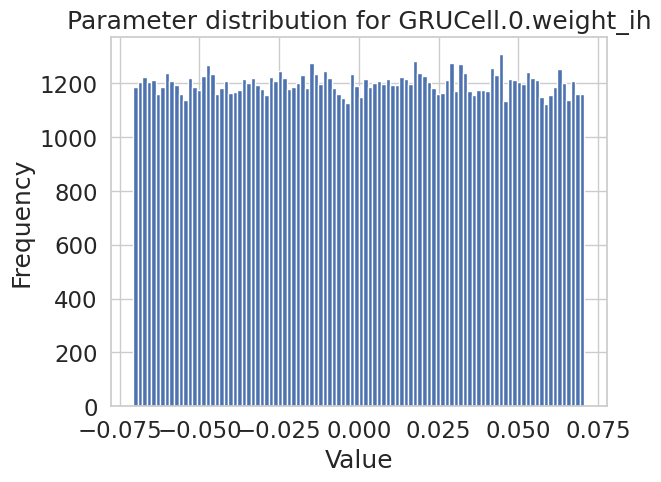

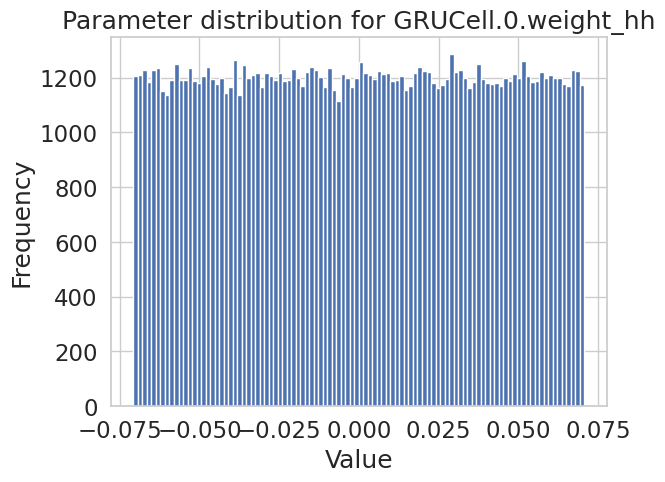

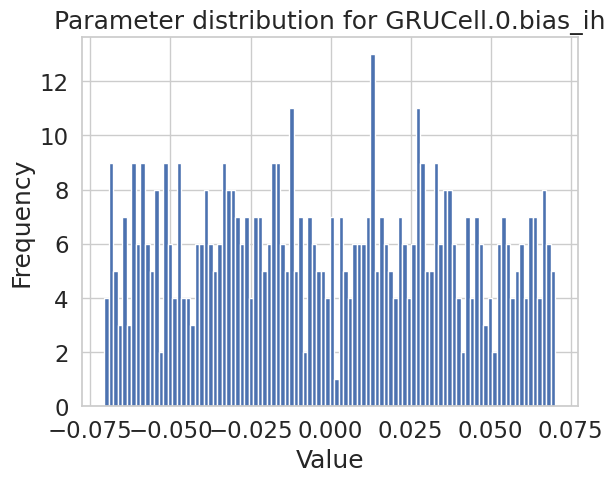

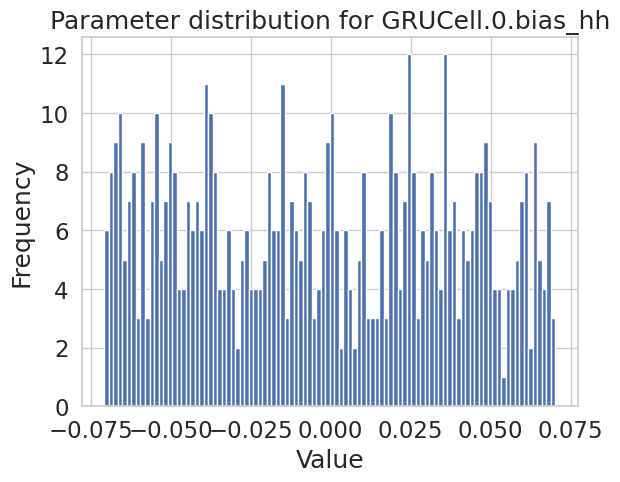

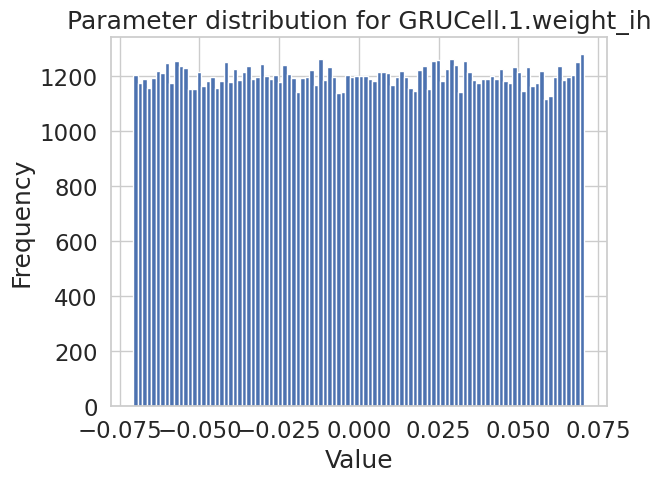

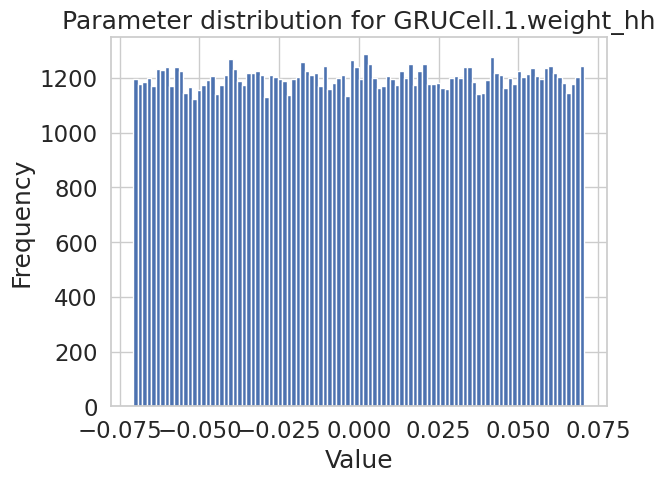

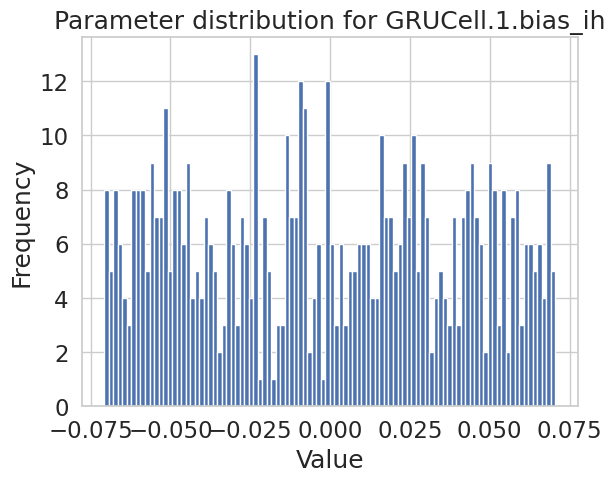

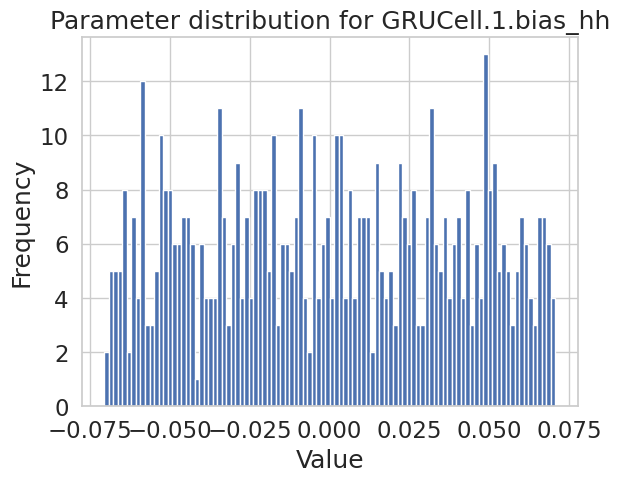

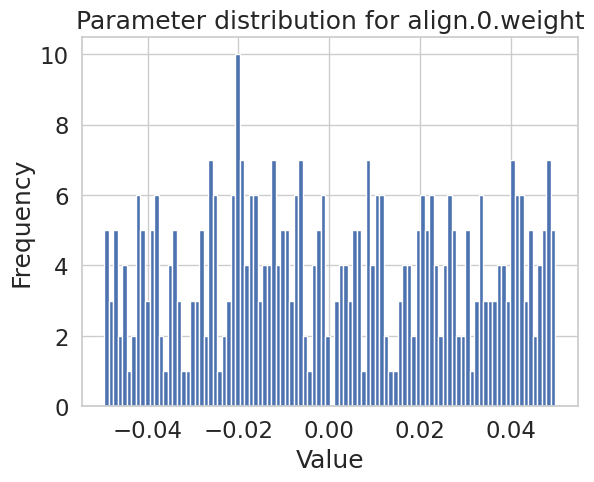

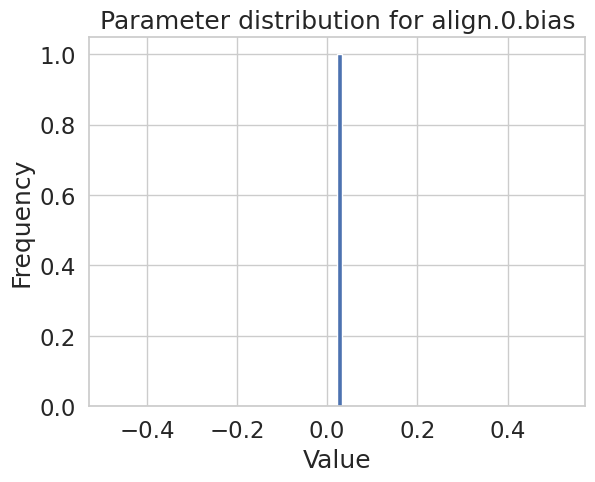

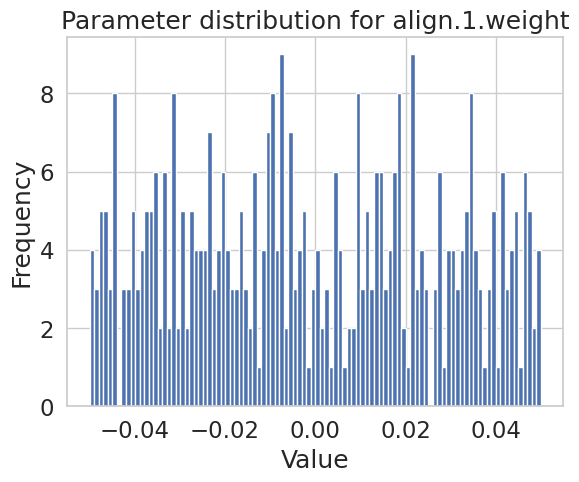

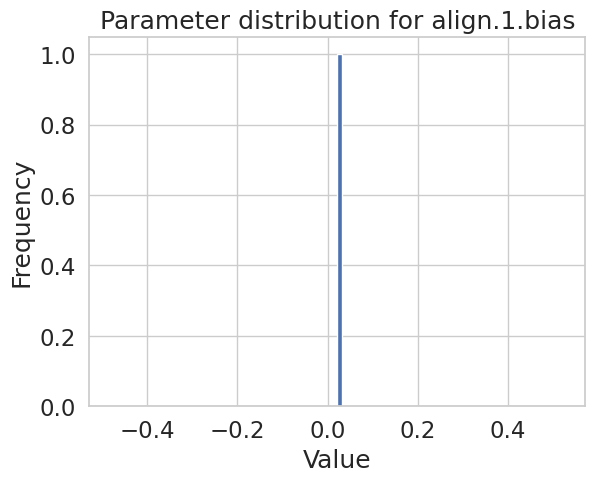

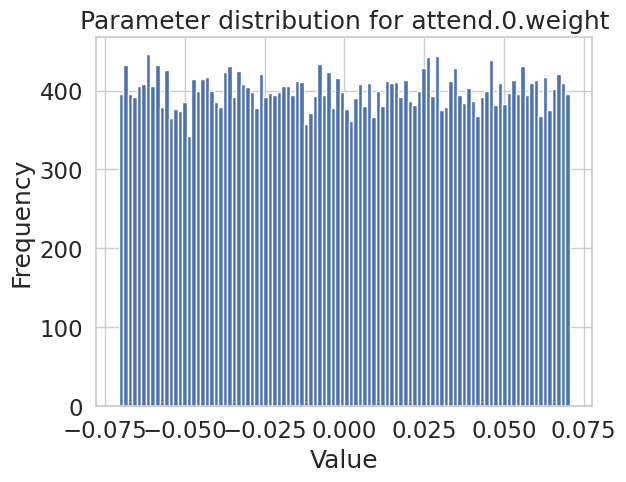

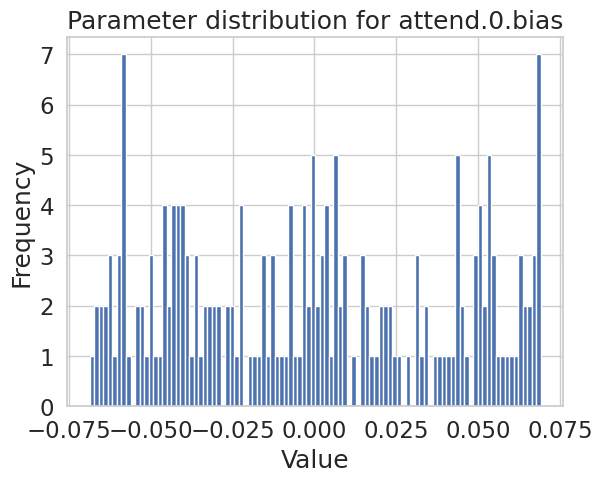

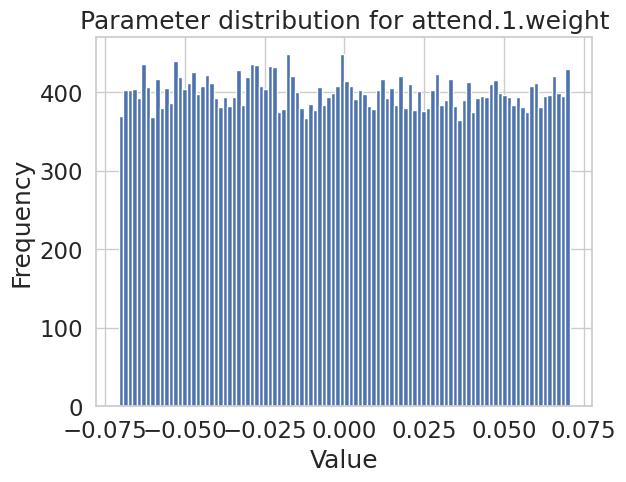

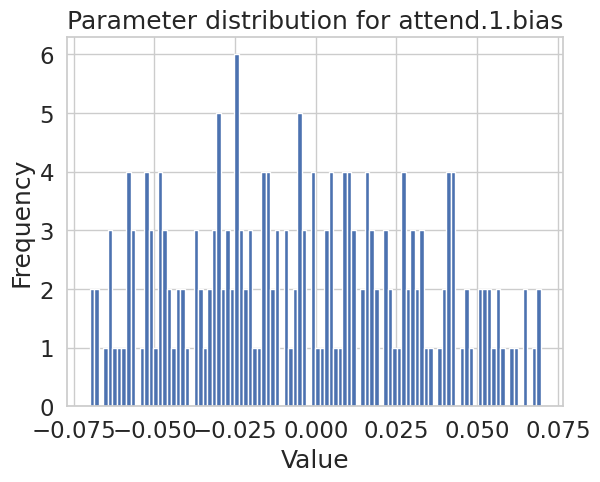

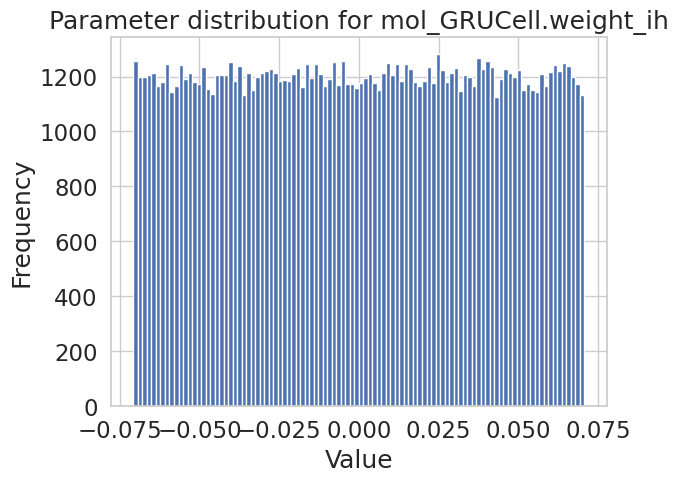

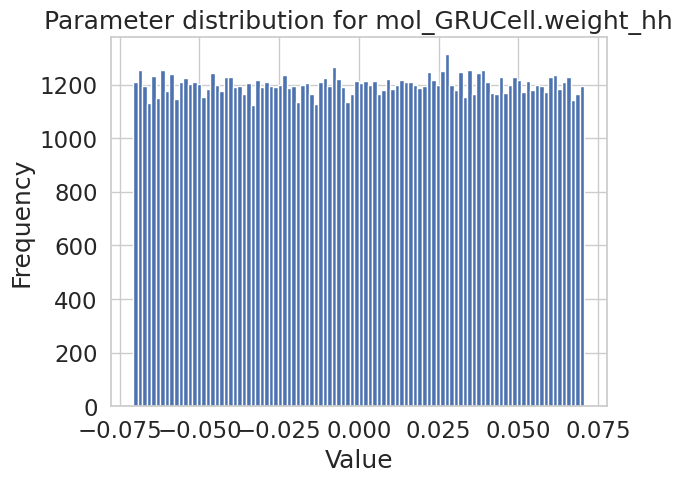

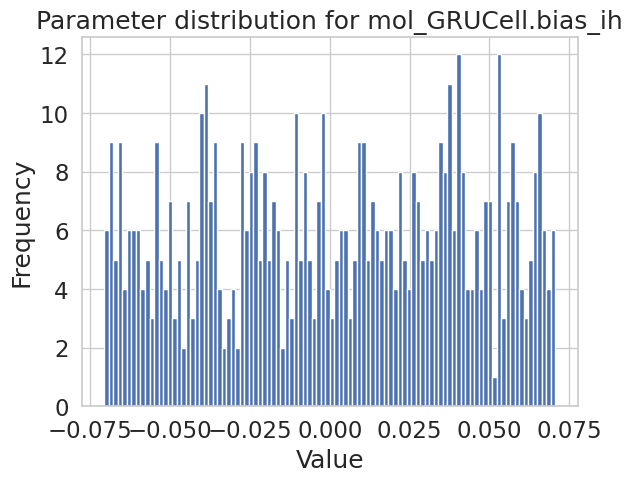

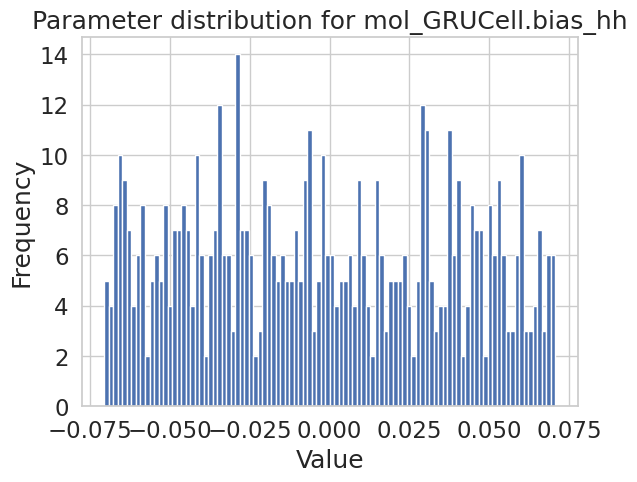

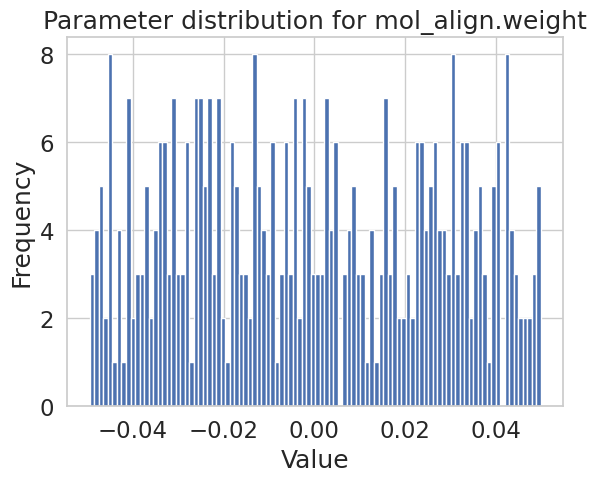

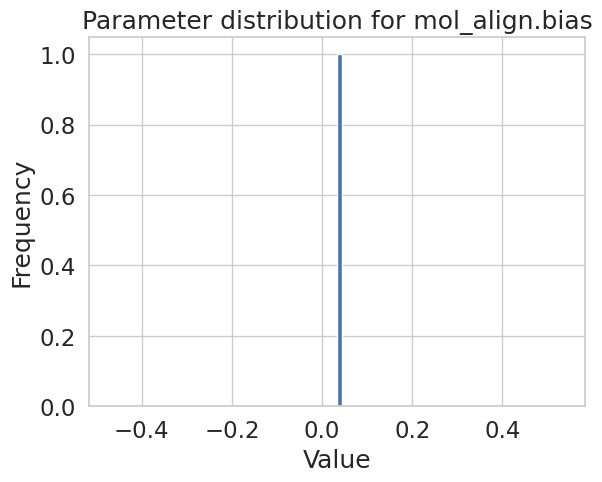

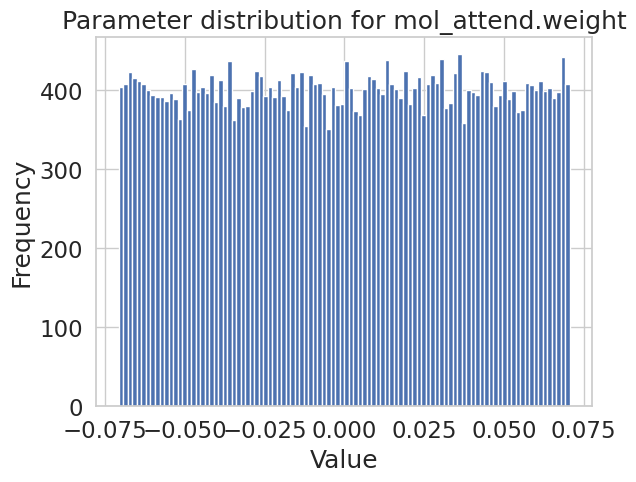

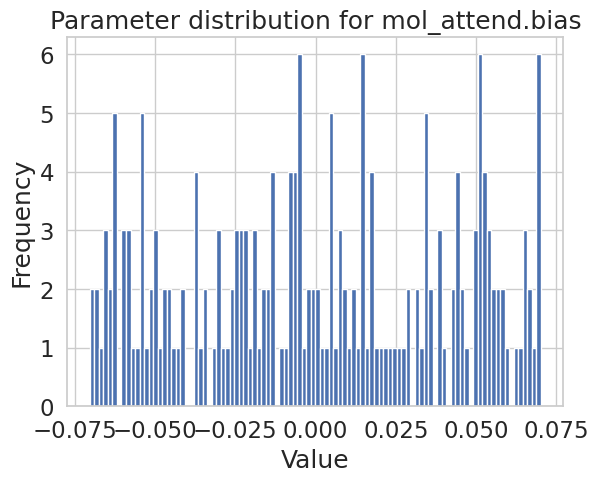

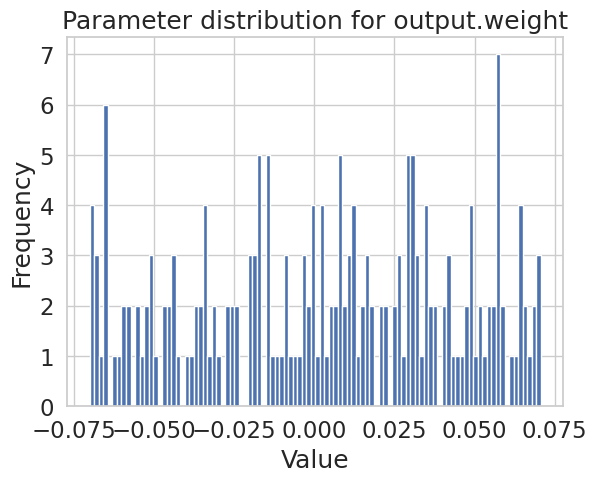

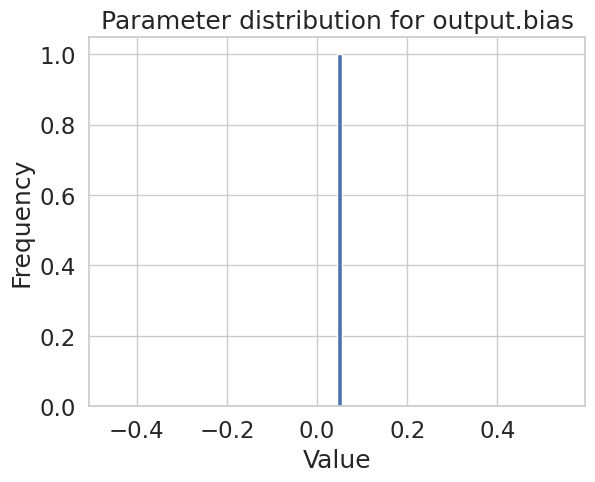

Fingerprint(
  (atom_fc): Linear(in_features=39, out_features=200, bias=True)
  (neighbor_fc): Linear(in_features=49, out_features=200, bias=True)
  (GRUCell): ModuleList(
    (0-1): 2 x GRUCell(200, 200)
  )
  (align): ModuleList(
    (0-1): 2 x Linear(in_features=400, out_features=1, bias=True)
  )
  (attend): ModuleList(
    (0-1): 2 x Linear(in_features=200, out_features=200, bias=True)
  )
  (mol_GRUCell): GRUCell(200, 200)
  (mol_align): Linear(in_features=400, out_features=1, bias=True)
  (mol_attend): Linear(in_features=200, out_features=200, bias=True)
  (dropout): Dropout(p=0.03, inplace=False)
  (output): Linear(in_features=200, out_features=1, bias=True)
)
Total Trainable Parameters: 863604
atom_fc.weight                           [200, 39]
atom_fc.bias                             [200]
neighbor_fc.weight                       [200, 49]
neighbor_fc.bias                         [200]
GRUCell.0.weight_ih                      [600, 200]
GRUCell.0.weight_hh                     

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)

# num_atom_features 和 num_bond_features 分别表示每个原子和键的特征数量，决定了模型需要的输入大小。
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

loss_function = nn.MSELoss() # 这里使用均方误差（Mean Squared Error）作为损失函数，通常用于回归任务
model = Fingerprint(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)

model.to(device) # 将模型移至 GPU 上进行计算

# 优化器选择
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

# 统计模型中所有参数的总数量，便于了解模型的大小
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("toal params in model:",params)

# 打印模型参数名称与形状
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

# 后序增加的可视化部分:(fujun)
# 1.用 直方图 展示模型参数的分布，看看哪些层的权重比较大或比较小
for name, param in model.named_parameters():
    if param.requires_grad:
        plt.hist(param.data.cpu().numpy().flatten(), bins=100)
        plt.title(f"Parameter distribution for {name}")
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        plt.show()

# 2.使用 torchsummary 来概述模型结构，显示每层的输出形状和参数数量
from torchsummary import summary
print(model)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Total Trainable Parameters: {params}")

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name:<40} {list(param.shape)}")

x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, _ = get_smiles_array([canonical_smiles_list[0]], feature_dicts)

# 转为 Tensor 并移动到 GPU（如果有）
x_atom = torch.Tensor(x_atom).cuda()
x_bonds = torch.Tensor(x_bonds).cuda()
x_atom_index = torch.LongTensor(x_atom_index).cuda()
x_bond_index = torch.LongTensor(x_bond_index).cuda()
x_mask = torch.Tensor(x_mask).cuda()

with torch.no_grad():
    atom_out, mol_out = model(x_atom, x_bonds, x_atom_index, x_bond_index, x_mask)

print("atom-level output shape:", atom_out.shape)
print("mol-level output shape:", mol_out.shape)

# 4.目前使用的是 MSELoss，如果任务需要更高的准确度或特殊的输出（例如 AUC），可以考虑不同的损失函数。例如回归任务，使用 HuberLoss，对抗梯度爆炸更加鲁棒
# loss_function = nn.SmoothL1Loss()  # 或 nn.HuberLoss()

/tmp/ipykernel_6554/2793262525.py:23: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  torch.cuda.LongTensor(x_atom_index),


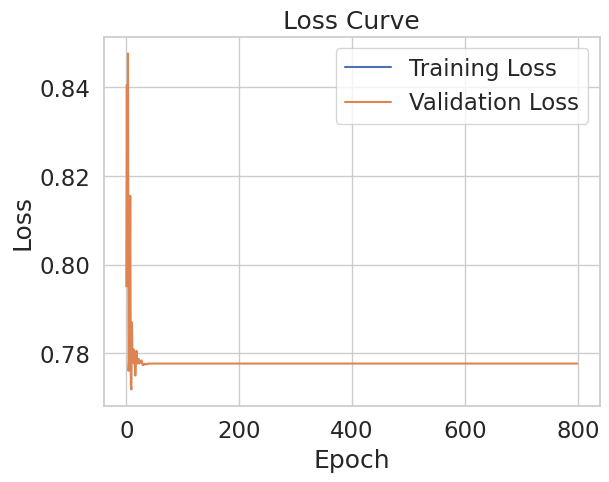

In [ ]:
from sklearn.metrics import r2_score

def train(model, dataset, optimizer, loss_function, epoch):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0, dataset.shape[0])
    np.random.shuffle(valList)  # 随机打乱数据
    batch_list = []
    
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   

    for counter, batch in enumerate(batch_list):
        batch_df = dataset.loc[batch, :]
        smiles_list = batch_df.cano_smiles.values
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list, feature_dicts)
        atoms_prediction, mol_prediction = model(
            torch.Tensor(x_atom), 
            torch.Tensor(x_bonds), 
            torch.cuda.LongTensor(x_atom_index), 
            torch.cuda.LongTensor(x_bond_index), 
            torch.Tensor(x_mask)
        )
        
        optimizer.zero_grad()  # 清空梯度
        loss = loss_function(mol_prediction, torch.Tensor(y_val).view(-1, 1))  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数


# 评估函数
def eval(model, dataset):
    model.eval()
    test_MAE_list = []
    test_MSE_list = []
    r2_list = []
    valList = np.arange(0, dataset.shape[0])
    batch_list = []
    
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)
    
    for counter, batch in enumerate(batch_list):
        batch_df = dataset.loc[batch, :]
        smiles_list = batch_df.cano_smiles.values
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list, feature_dicts)
        atoms_prediction, mol_prediction = model(
            torch.Tensor(x_atom), 
            torch.Tensor(x_bonds), 
            torch.cuda.LongTensor(x_atom_index), 
            torch.cuda.LongTensor(x_bond_index), 
            torch.Tensor(x_mask)
        )
        
        MAE = F.l1_loss(mol_prediction, torch.Tensor(y_val).view(-1, 1), reduction='mean')
        MSE = F.mse_loss(mol_prediction, torch.Tensor(y_val).view(-1, 1), reduction='mean')
        
        # R² score
        r2 = r2_score(y_val, mol_prediction.cpu().detach().numpy())
        
        test_MAE_list.append(MAE.data.squeeze().cpu().numpy())
        test_MSE_list.append(MSE.data.squeeze().cpu().numpy())
        r2_list.append(r2)

    return np.array(test_MAE_list).mean(), np.array(test_MSE_list).mean(), np.array(r2_list).mean()

# 学习率调度器
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# 训练过程可视化
train_losses = []
val_losses = []

for epoch in range(epochs):
    train_loss = train(model, train_df, optimizer, loss_function, epoch)
    train_losses.append(train_loss)

    val_loss, _, _ = eval(model, test_df)
    val_losses.append(val_loss)

    scheduler.step()  # 每个 epoch 后调整学习率

# 绘制训练和验证损失曲线
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 加载最佳模型
best_model = torch.load('saved_models/model_' + prefix_filename + '_' + start_time + '_' + str(best_param["test_epoch"]) + '.pt', map_location=device)
best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

# 将最佳模型的权重加载到当前模型
model.load_state_dict(best_model_wts)

# 检查权重是否一致
assert (best_model.align[0].weight == model.align[0].weight).all(), "Weights do not match!"

# 测试集的 MSE 和 MAE
test_MAE, test_MSE = eval(model, test_df)
print("Best epoch:", best_param["test_epoch"], "\n", "Test MSE:", test_MSE)

# 可视化 MSE 和 MAE 随 epoch 的变化
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_MSE_list)), train_MSE_list, label="Train MSE", color='blue')
plt.plot(range(len(test_MSE_list)), test_MSE_list, label="Test MSE", color='orange')
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("MSE vs Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(train_MAE_list)), train_MAE_list, label="Train MAE", color='blue')
plt.plot(range(len(test_MAE_list)), test_MAE_list, label="Test MAE", color='orange')
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("MAE vs Epoch")
plt.legend()

plt.tight_layout()
plt.show()

# 绘制预测值与实际值的散点图
# 获取模型在测试集上的预测值
model.eval()
test_smiles = test_df['cano_smiles'].values
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, _ = get_smiles_array(test_smiles, feature_dicts)
y_true = test_df[tasks[0]].values
y_pred = model(torch.Tensor(x_atom), torch.Tensor(x_bonds), torch.cuda.LongTensor(x_atom_index), torch.cuda.LongTensor(x_bond_index), torch.Tensor(x_mask))

# 绘制散点图
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred.cpu().detach().numpy(), alpha=0.7, color='purple')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'k--', lw=2)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True Values vs Predictions")
plt.show()